<a href="https://colab.research.google.com/github/sergioar3143/AprendizajeProfundo/blob/main/Clasificacion_grupo_etario_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install einops
!pip install -q torchinfo
!pip install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 825.7 kB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import PIL
import copy
from torch import nn
from torch.optim import Adam
from torch.optim import SGD
from sklearn.model_selection import train_test_split
import torchvision as tv
import gdown
# marcas de tiempo
import datetime
# explorar el sistema de archivos
import glob
# sistema de archivos
import os
# funciones aleatorias
import random
# marcas de tiempo
import time
# tomar n elementos de una secuencia
from itertools import islice as take
# inspección de arquitectura
from torchinfo import summary
# barra de progreso
from tqdm.auto import trange
# imágenes
from PIL import Image

from einops import rearrange, repeat

# Por reproducibilidad
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

URL_trainval="https://drive.google.com/uc?id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86"
if not os.path.exists("./fairface-img-margin025-trainval.zip"):
  gdown.download(URL_trainval, "./fairface-img-margin025-trainval.zip", quiet=False)

URL_train_csv="https://drive.google.com/uc?id=1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH"
if not os.path.exists("./fairface_label_train.csv"):
  gdown.download(URL_train_csv, "./fairface_label_train.csv", quiet=False)

URL_val_csv="https://drive.google.com/uc?id=1wOdja-ezstMEp81tX1a-EYkFebev4h7D"
if not os.path.exists("./fairface_label_val.csv"):
  gdown.download(URL_val_csv, "./fairface_label_val.csv", quiet=False)

if not os.path.exists("./FairFace"):
    !unzip "./fairface-img-margin025-trainval.zip" -d "./FairFace"

Downloading...
From: https://drive.google.com/uc?id=1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86
To: /content/fairface-img-margin025-trainval.zip
100%|██████████| 578M/578M [00:06<00:00, 93.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH
To: /content/fairface_label_train.csv
100%|██████████| 3.79M/3.79M [00:00<00:00, 181MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wOdja-ezstMEp81tX1a-EYkFebev4h7D
To: /content/fairface_label_val.csv
100%|██████████| 448k/448k [00:00<00:00, 116MB/s]


Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: ./FairFace/val/5370.jpg  
  inflating: ./FairFace/val/5596.jpg  
  inflating: ./FairFace/val/5875.jpg  
  inflating: ./FairFace/val/5878.jpg  
  inflating: ./FairFace/val/5879.jpg  
  inflating: ./FairFace/val/5883.jpg  
  inflating: ./FairFace/val/6126.jpg  
  inflating: ./FairFace/val/6132.jpg  
  inflating: ./FairFace/val/6144.jpg  
  inflating: ./FairFace/val/6150.jpg  
  inflating: ./FairFace/val/6340.jpg  
  inflating: ./FairFace/val/7190.jpg  
  inflating: ./FairFace/val/7734.jpg  
  inflating: ./FairFace/val/7747.jpg  
  inflating: ./FairFace/val/7872.jpg  
  inflating: ./FairFace/val/7940.jpg  
  inflating: ./FairFace/val/8065.jpg  
  inflating: ./FairFace/val/8069.jpg  
  inflating: ./FairFace/val/8125.jpg  
  inflating: ./FairFace/val/8202.jpg  
  inflating: ./FairFace/val/8204.jpg  
  inflating: ./FairFace/val/8205.jpg  
  inflating: ./FairFace/val/8268.jpg  
  inflating: ./FairFace/val/8270.jpg  
  i

In [3]:
# media y varianza de de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# filas y columnas de la cuadrícula
ROWS, COLS = 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Despliega un ejempos en una cuadrícula."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Despliega un lote en una cuadrícula."""
    #x = x.permute(0, 2, 3, 1).cpu().numpy()
    # denormalizamos
    for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        x[:, c] = x[:, c] * std + mean
    x *= 255
    # rotamos canales
    x = x.permute(0, 2, 3, 1).cpu()
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos lote
    display_grid(x, titles, rows, cols, figsize)

In [4]:
df_train = pd.read_csv('./fairface_label_train.csv')
df_val = pd.read_csv('./fairface_label_val.csv')
df_train.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [5]:
clase=list(np.unique(df_train['age']))
clase_a_ind = {c:i for i,c in enumerate(clase)}
ind_a_clase = {i:c for i,c in enumerate(clase)}

for i in clase:
  print(f'A la clase de {i} años le corresponde el indice {clase_a_ind[i]}')

A la clase de 0-2 años le corresponde el indice 0
A la clase de 10-19 años le corresponde el indice 1
A la clase de 20-29 años le corresponde el indice 2
A la clase de 3-9 años le corresponde el indice 3
A la clase de 30-39 años le corresponde el indice 4
A la clase de 40-49 años le corresponde el indice 5
A la clase de 50-59 años le corresponde el indice 6
A la clase de 60-69 años le corresponde el indice 7
A la clase de more than 70 años le corresponde el indice 8


In [6]:
clase=list(np.unique(df_train['age']))

# Diccionario de etiqueta a la clase:
ind_a_clase = {i:c for i,c in enumerate(clase)}

# Función para pasar un lote de etiquetas a sus clases:
def names_batch(targets):
  ind_a_clases = [ind_a_clase[torch.argmax(y).item()] for y in targets]
  return ind_a_clases

In [7]:
df_train['ind']=0
df_val['ind']=0
for i in clase:
  idx=df_train.loc[:,'age']==i
  df_train.loc[idx, 'ind']=clase_a_ind[i]

  idx=df_val.loc[:,'age']==i
  df_val.loc[idx, 'ind']=clase_a_ind[i]

In [8]:
X_train, X_val, y_train, y_val = train_test_split(df_train['file'], df_train['ind'], test_size=0.3, random_state=42, shuffle=True, stratify=df_train['ind'])
X_test , y_test = df_val['file'], df_val['ind']

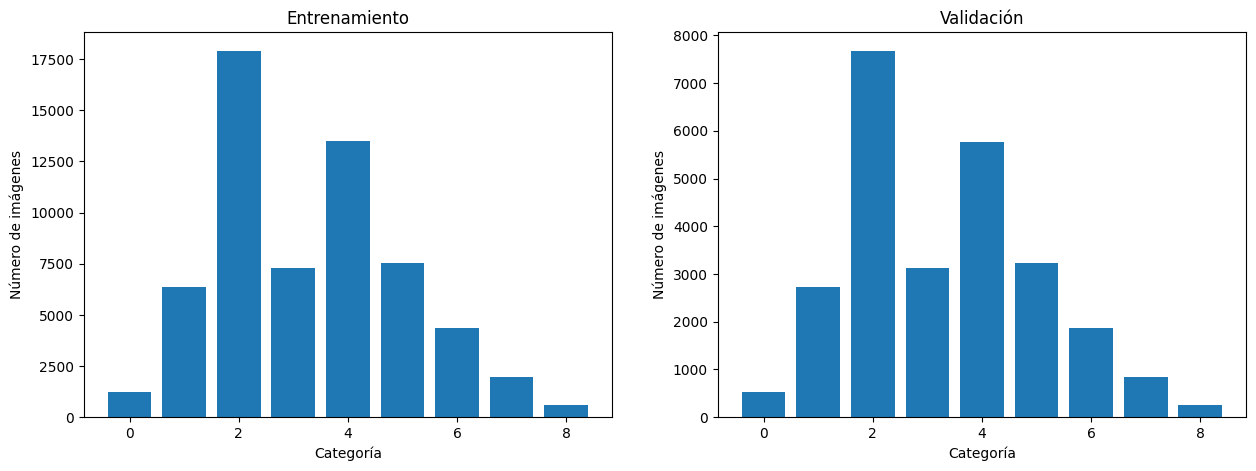

In [9]:
idx_ent, cuentas_ent = np.unique(y_train, return_counts=True)
idx_val, cuentas_val = np.unique(y_val, return_counts=True)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].bar(x=idx_ent, height=cuentas_ent)
axs[0].set_title('Entrenamiento')
axs[0].set_xlabel('Categoría')
axs[0].set_ylabel('Número de imágenes')

axs[1].bar(x=idx_val, height=cuentas_val)
axs[1].set_title('Validación')
axs[1].set_xlabel('Categoría')
axs[1].set_ylabel('Número de imágenes')

plt.show()

In [10]:
class Face_age(Dataset):
  def __init__(self, x, y, raiz, transform = None):
    self.x = x
    self.y = y
    self.raiz = raiz
    self.transform = transform
    self.disp = 'cuda' if torch.cuda.is_available() else 'cpu'

  def __getitem__(self, idx):
    img = PIL.Image.open(self.raiz+"/"+self.x.iloc[idx])
    cat = self.y.iloc[idx]
    cat = nn.functional.one_hot(torch.tensor(cat), num_classes=9)
    cat = cat.to(dtype=torch.float32, device=self.disp)

    if self.transform:
      img = self.transform(img)
      img = img.to(self.disp)

    return img, cat

  def __len__(self):
    return len(self.x)


In [11]:
dir_raiz = 'FairFace'
ds_ent = Face_age(X_train, y_train, dir_raiz)
ds_ent.disp="cpu"

In [12]:
it_ent = iter(ds_ent)
img_ent, cat_ent = next(it_ent)

cat_ent=cat_ent.cpu().numpy()
cat_ent=np.argmax(cat_ent)

print(f'Imagen = {img_ent}, Categoría = {cat_ent}')


Imagen = <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224 at 0x7BBB40A72E00>, Categoría = 7


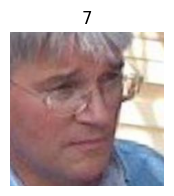

In [13]:
test_batch = next(iter(ds_ent))
names_batch(test_batch[1])

plt.figure(figsize = (2,2))
plt.imshow(test_batch[0])
plt.title(cat_ent)
plt.axis('off')
plt.show()


In [14]:
IMG_SIZE = 64

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

tsfm = transforms.Compose([
  transforms.Resize(IMG_SIZE,antialias = True),
  transforms.ToTensor(),
  transforms.Normalize(mean = IMAGENET_MEAN , std=IMAGENET_STD)
])

tsfm2 = transforms.Compose([transforms.RandomResizedCrop(IMG_SIZE, scale = (0.85, 1.0),antialias = True),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = IMAGENET_MEAN , std=IMAGENET_STD)
])


x shape=torch.Size([32, 3, 64, 64]) dtype=torch.float32
y shape=torch.Size([32, 9]) dtype=torch.float32


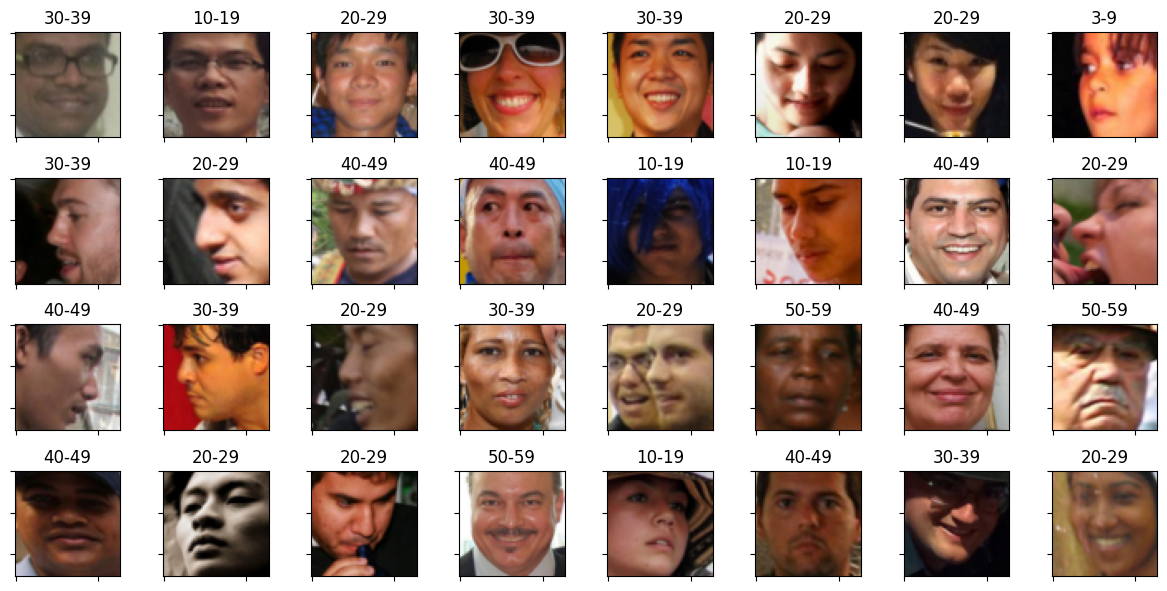

In [15]:
dir_raiz = 'FairFace'
trn_ds = Face_age(X_train, y_train, dir_raiz, transform=tsfm2)
val_ds = Face_age(X_val, y_val, dir_raiz, transform=tsfm)

trn_dl = DataLoader(trn_ds, batch_size=32, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

train_batch = next(iter(trn_dl))
x, y = train_batch[0] , train_batch[1]
titles = names_batch(y)
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, titles, ROWS, COLS)


In [16]:
trn_dl = DataLoader(trn_ds, batch_size=128, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=False)

In [17]:
def guarda_ckpt(ckptpath, modelo, epoca, opt):
  estado_modelo = {'epoch': epoca,
                   'model_state_dict': modelo.state_dict(),
                   'optimizer_state_dict': opt.state_dict()}
  torch.save(estado_modelo, ckptpath)

In [18]:
def registra_info_tboard(writer, epoca, hist):
  for (m,v) in hist.items():
    writer.add_scalar(m, v[epoca], epoca)

In [19]:
def exactitud(y_hat, y):
  cmp = y_hat.argmax(dim=-1) == y.argmax(dim=-1)
  #cmp = y_hat.argmax(dim=-1) == y
  aciertos = torch.count_nonzero(cmp)
  return aciertos / cmp.shape[0]

In [20]:
def paso_ent(modelo,
             fp,
             metrica,
             opt,
             X,
             y):
  opt.zero_grad() # se ponen los gradientes asociados a los parámetros
                    # a actualizaren en cero
  y_hat = modelo(X) # se propagan las entradas para obtener las predicciones
  perdida = fp(y_hat, y) # se calcula la pérdida
  perdida.backward() # se obtienen los gradientes
  opt.step() # se actualizan todos los parámetros del modelo

  with torch.no_grad():
    perdida_paso = perdida.cpu().numpy() # convertimos la pérdida (instancia de
                                         # Tensor de orden 0) a NumPy, para
                                         # lo que es necesario moverla a CPU
    metricas_paso = metrica(y_hat, y)

  return perdida_paso, metricas_paso

In [21]:
def entrena(modelo,
            fp,
            metrica,
            opt,
            entdl,
            valdl,
            disp,
            ckptpath,
            n_epocas = 10,
            tbdir = 'runs/'):
  n_lotes_ent = len(entdl)
  n_lotes_val = len(valdl)

  hist = {'perdida_ent':np.zeros(n_epocas),
          'perdida_val': np.zeros(n_epocas),
          metrica.__name__ + '_ent': np.zeros(n_epocas),
          metrica.__name__ + '_val': np.zeros(n_epocas)}

  tbwriter = SummaryWriter(tbdir)
  perdida_min = torch.inf
  mejor_modelo = copy.deepcopy(modelo)

  for e in range(n_epocas):
    # bucle de entrenamiento
    modelo.train()
    for p, (Xlote,ylote) in enumerate(entdl):
      #print(Xlote.shape)
      Xlote = Xlote.to(disp)
      ylote = ylote.to(disp)

      perdida_paso, metrica_paso = paso_ent(modelo,
                                            fp,
                                            metrica,
                                            opt,
                                            Xlote,
                                            ylote)

      hist['perdida_ent'][e] += perdida_paso
      hist[metrica.__name__ + '_ent'][e] += metrica_paso

    # bucle de validación
    modelo.eval()
    with torch.no_grad():
      for Xlote,ylote in valdl:
        Xlote = Xlote.to(disp)
        ylote = ylote.to(disp)

        y_hat = modelo(Xlote)

        hist['perdida_val'][e] += fp(y_hat, ylote)
        hist[metrica.__name__ + '_val'][e] += metrica(y_hat, ylote)

    hist['perdida_ent'][e] /=  n_lotes_ent
    hist[metrica.__name__ + '_ent'][e] /= n_lotes_ent
    hist['perdida_val'][e] /=  n_lotes_val
    hist[metrica.__name__ + '_val'][e] /= n_lotes_val

    # guardamos checkpoint y copiamos pesos y sesgos del modelo
    # actual si disminuye la metrica a monitorear
    if hist['perdida_val'][e] < perdida_min:
      mejor_modelo.load_state_dict(modelo.state_dict())
      guarda_ckpt(ckptpath, modelo, e, opt)

    registra_info_tboard(tbwriter, e, hist)

    print(f'\nÉpoca {e}: '
          f'Perdida(E) = {hist["perdida_ent"][e]:.3f}, '
          f'{metrica.__name__}(E) = {hist[metrica.__name__ + "_ent"][e]:.3f}, '
          f'Perdida(V) = {hist["perdida_val"][e]:.3f}, '
          f'{metrica.__name__}(V) = {hist[metrica.__name__ + "_val"][e]:.3f}')

  return modelo, mejor_modelo, hist

In [22]:
class ProductoPuntoEscalado(nn.Module):
  def __init__(self,
               masc = False):
    super(ProductoPuntoEscalado, self).__init__()
    self.masc = masc

  def forward(self, Q, K, V):
    # Obtenemos dimensiones
    m, n_cabezas, l, d_k = K.shape
    d_v = V.shape[-1]

    # Cambiamos la forma: [m, n_cabezas, l, d_k] -> [m * n_cabezas, l, d_k]
    Q = Q.reshape(m * n_cabezas, l, d_k)
    K = K.reshape(m * n_cabezas, l, d_k)
    V = V.reshape(m * n_cabezas, l, d_v)

    # Q y K tienen forma [m * n_cabezas, l, d_k],
    # por lo que se transponen las dos últimas dimensiones de K
    # QK: [m * n_cabezas, l, l]
    QK = torch.bmm(Q, K.transpose(1, 2))

    # se escalan los valores QK
    QK_esc = QK / torch.math.sqrt(d_k)

    if self.masc:
      # Creamos una matriz triangular superior binaria (excluyendo la diagonal)
      masc = torch.triu(torch.ones((l, l), dtype = torch.bool, device = Q.device),
                     diagonal = 1)
      # Ponemos los valores de QK_esc en los que la máscara sea 1 a -inf
      QK_esc = QK_esc.masked_fill_(masc, -torch.inf)

    # mapas de atención: [m * n_cabezas, l, l] -> [m * n_cabezas, l, l]
    alfas = nn.functional.softmax(QK_esc, dim=-1)

    # vectores de salida y
    # alfas: [m * n_cabezas, l, l], V: [m * n_cabezas, l, d_v]
    # Y: [m * n_cabezas, l, d_v]
    Y = torch.bmm(alfas, V)

    # Cambiamos la forma: [m * n_cabezas, l, d_v] -> [m, n_cabezas, l, d_v]
    Y = Y.reshape(m, n_cabezas, l, d_v)

    # Cambiamos la forma: [m * n_cabezas, l, l] -> [m, n_cabezas, l, l]
    alfas = alfas.reshape(m, n_cabezas, l, l)

    return Y, alfas

In [23]:
class AtencionMulticabeza(nn.Module):
  def __init__(self,
               d_modelo,
               n_cabezas,
               masc = False):
    super(AtencionMulticabeza, self).__init__()

    self.n_cabezas = n_cabezas
    self.d_modelo = d_modelo

    self.ppe = ProductoPuntoEscalado(masc = masc)
    self.proy_Q = nn.Linear(self.d_modelo, self.d_modelo, bias = False)
    self.proy_K = nn.Linear(self.d_modelo, self.d_modelo, bias = False)
    self.proy_V = nn.Linear(self.d_modelo, self.d_modelo, bias = False)
    self.proy_sal = nn.Linear(self.d_modelo, self.d_modelo)

  def forward(self, x):
    m, l, d_modelo = x.shape

    # Cambiamos la forma del tensor x
    # [m, l, d_modelo] -> [m * l, d_modelo]
    x = x.reshape(m * l, d_modelo)

    # Proyectamos vectores en x a Q, K, V
    # [m * l, d_modelo] -> [m * l, d_modelo]
    Q = self.proy_Q(x)
    K = self.proy_K(x)
    V = self.proy_V(x)

    # Cambiamos la forma: [m * l, d_modelo] -> [m, l, n_cabezas, d_k]
    # d_k = d_v = self.d_modelo // self.n_cabezas
    Q = Q.reshape(m, l, self.n_cabezas, self.d_modelo // self.n_cabezas)
    K = K.reshape(m, l, self.n_cabezas, self.d_modelo // self.n_cabezas)
    V = V.reshape(m, l, self.n_cabezas, self.d_modelo // self.n_cabezas)

    # Transponemos el eje de las cabezas a la segunda posición del tensor y
    # creamos copia (con .contiguous()) para que esté almacenado en memoria de
    # forma contigua (.transpose() hace que ya no sea así).
    # [m, l, n_cabezas, d_k] -> [m, n_cabezas, l, d_k]
    Q = Q.transpose(1, 2).contiguous()
    K = K.transpose(1, 2).contiguous()
    V = V.transpose(1, 2).contiguous()

    # Calculamos el producto punto escalado con Q, K y V
    # Q, K: [m, n_cabezas, l, d_k], V:[m, n_cabezas, l, d_v]
    # Y: [m, n_cabezas, l, d_v], alfas: [m, n_cabezas, l, l]
    Y, alfas = self.ppe(Q, K, V)

    # Transponermos el eje de cabezas a la penúltima posición:
    # [m, n_cabezas, l, d_k] -> [m, l, n_cabezas, d_k]
    Y = Y.transpose(1, 2).contiguous()

    # Concatemanos los vectores de todas las cabezas en un solo vector
    # [m, l, n_cabezas, d_k] -> [m * l, d_modelo]
    # d_modelo = n_cabezas * d_k
    Y = Y.reshape(m * l, self.d_modelo)

    # Proyectamos la vectores concatenados para obtener la salida
    # [m * l, d_modelo] -> [m * l, d_modelo]
    Y = self.proy_sal(Y)

    # Concatemanos los vectores de todas las cabezas en un solo vector
    # [m * l, d_modelo] -> [m, l, d_modelo]
    Y = Y.reshape(m, l, self.d_modelo)

    return Y, alfas

In [24]:
class RedDensaPosicion(nn.Module):
  def __init__(self,
               d_modelo,
               d_ff,
               p_dropout):

    super(RedDensaPosicion, self).__init__()
    self.d_modelo = d_modelo
    self.d_ff = d_ff

    self.densa1 = nn.Linear(self.d_modelo, self.d_ff)
    self.densa2 = nn.Linear(self.d_ff, self.d_modelo)

    self.dropout1 = nn.Dropout(p_dropout)
    self.dropout2 = nn.Dropout(p_dropout)

  def forward(self, x):
    m, l, d_modelo = x.shape

    # Cambiamos la forma: [m, l, d_modelo] -> [m * l, d_modelo]
    x = x.reshape(m * l, d_modelo)

    # Pasamos el tensor redimensionado por la red densa
    # [m * l, d_modelo] -> [m * l, d_modelo]
    x = self.densa1(x)
    x = nn.functional.gelu(x)
    x = self.dropout1(x)

    x = self.densa2(x)
    x = self.dropout2(x)

    # Lo regresamos a su forma original
    # [m * l, d_modelo] -> [m, l, d_modelo]
    x = x.reshape(m, l, d_modelo)

    return x

In [25]:
class BloqueTransformer(nn.Module):
  def __init__(self,
               d_modelo,
               n_cabezas,
               d_rdp,
               p_dropout = 0.0,
               masc = False):
    super(BloqueTransformer, self).__init__()

    self.amc = AtencionMulticabeza(d_modelo = d_modelo,
                                   n_cabezas = n_cabezas,
                                   masc = masc)
    self.norm1 = nn.LayerNorm(d_modelo)
    self.norm2 = nn.LayerNorm(d_modelo)

    self.dropout1 = nn.Dropout(p_dropout)

    self.mlp = RedDensaPosicion(d_modelo, d_rdp, p_dropout)

  def forward(self, x):
    x_ln1 = self.norm1(x)
    salidas_amc, alfas = self.amc(x_ln1)
    salidas_amc = self.dropout1(salidas_amc)

    x = salidas_amc + x
    x_ln2 = self.norm2(x)
    mlp = self.mlp(x_ln2)
    out = mlp + x

    return out

In [26]:
test_layer = BloqueTransformer(32, 4, 256)
test_layer(torch.ones([1, 32, 32])).shape

torch.Size([1, 32, 32])

In [27]:
class ViT(nn.Module):
    def __init__(self, img_size, patch_size, out_dim, d_modelo,
                 depth, n_cabezas, mlp_dim, dropout):
        super().__init__()
        self.d_modelo = d_modelo

        # N = H*W/(P^2)
        self.n_patches = (img_size // patch_size) ** 2

        input_projection = 3*(patch_size ** 2) # C*PP

        self.projection = nn.Linear(input_projection, d_modelo) #

        self.pos_embedding = nn.Parameter(
            torch.randn(1, self.n_patches + 1, d_modelo))


        self.cls_token = nn.Parameter(torch.randn(1, 1, d_modelo))

        bloques = [BloqueTransformer(d_modelo,
                                     n_cabezas,
                                     mlp_dim,
                                     dropout,
                                     masc = False) for _ in range(depth)]
        self.transformer = nn.Sequential(*bloques)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(d_modelo),
            nn.Linear(d_modelo, out_dim),
        )

    def forward(self, x):
        B = x.shape[0]

        # Patches
        # N x (P^2 * C)
        # Donde:
        # N = HW/P^2

        #img_patches0 = x.reshape(B, self.n_patches, int((patch_size*patch_size)*C))

        #img_patches = rearrange(x,'b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)', patch_x=patch_size, patch_y=patch_size)
        img_patches = rearrange(x,'b c (x patch_x) (y patch_y) -> b (x y) (patch_x patch_y c)', patch_x=patch_size, patch_y=patch_size)

        # Linear Projection
        x = self.projection(img_patches)

        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat((cls_token, x), dim=1)
        x += self.pos_embedding

        x = self.transformer(x)
        x = x[:, 0, :]
        return self.mlp_head(x)

In [28]:
dir_raiz = 'FairFace'

t_patch= transforms.Compose([
  transforms.Resize(IMG_SIZE,antialias = True),
  transforms.ToTensor()
])

patch_ds = Face_age(X_train, y_train, dir_raiz, transform=t_patch)

patch_dl = DataLoader(patch_ds, batch_size=32, shuffle=False, drop_last=False)
train_batch = next(iter(patch_dl))

In [29]:
patch_size = 16
out_dim = 9
d_modelo = 32
depth = 3

n_cabezas = 4
mlp_dim = 256
dropout = 0.5

vit = ViT(IMG_SIZE, patch_size, out_dim, d_modelo, depth, n_cabezas, mlp_dim, dropout)
vit = vit.to("cuda")
test_out = vit(train_batch[0])
test_out.shape

torch.Size([32, 9])

In [30]:
print("Dimensión del batch antes del rearrange:")
print(train_batch[0].shape)
##Se dividen las imagenes en parches
print("Dimensión del batch después del rearrange:")
img_patches = rearrange(train_batch[0], 'b c (x patch_x) (y patch_y) -> b (x y) c patch_x patch_y',  patch_x=patch_size, patch_y=patch_size)
print(img_patches.shape)

Dimensión del batch antes del rearrange:
torch.Size([32, 3, 64, 64])
Dimensión del batch después del rearrange:
torch.Size([32, 16, 3, 16, 16])


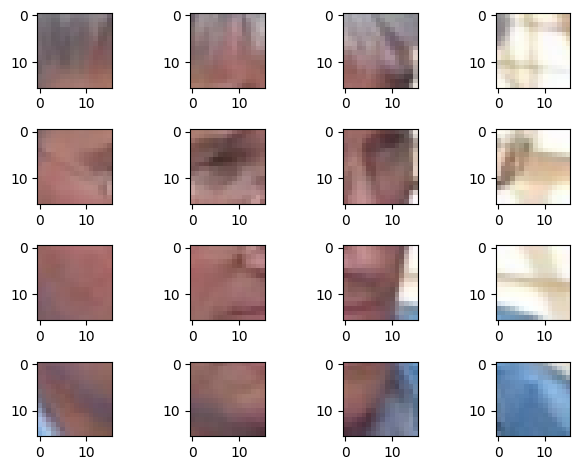

In [31]:
#Visualización de una imagen dividida en parches
img_patches=img_patches[0]

fig, axs = plt.subplots(4, 4)
axs[0, 0].imshow(img_patches[0].permute(1, 2, 0).cpu().numpy())
axs[0, 1].imshow(img_patches[1].permute(1, 2, 0).cpu().numpy())
axs[0, 2].imshow(img_patches[2].permute(1, 2, 0).cpu().numpy())
axs[0, 3].imshow(img_patches[3].permute(1, 2, 0).cpu().numpy())
axs[1, 0].imshow(img_patches[4].permute(1, 2, 0).cpu().numpy())
axs[1, 1].imshow(img_patches[5].permute(1, 2, 0).cpu().numpy())
axs[1, 2].imshow(img_patches[6].permute(1, 2, 0).cpu().numpy())
axs[1, 3].imshow(img_patches[7].permute(1, 2, 0).cpu().numpy())
axs[2, 0].imshow(img_patches[8].permute(1, 2, 0).cpu().numpy())
axs[2, 1].imshow(img_patches[9].permute(1, 2, 0).cpu().numpy())
axs[2, 2].imshow(img_patches[10].permute(1, 2, 0).cpu().numpy())
axs[2, 3].imshow(img_patches[11].permute(1, 2, 0).cpu().numpy())
axs[3, 0].imshow(img_patches[12].permute(1, 2, 0).cpu().numpy())
axs[3, 1].imshow(img_patches[13].permute(1, 2, 0).cpu().numpy())
axs[3, 2].imshow(img_patches[14].permute(1, 2, 0).cpu().numpy())
axs[3, 3].imshow(img_patches[15].permute(1, 2, 0).cpu().numpy())
fig.tight_layout()


In [ ]:
#ecm = nn.MSELoss()
model = ViT(IMG_SIZE, patch_size, out_dim, d_modelo, depth, n_cabezas, mlp_dim, dropout)
disp = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(disp)
ecm = nn.CrossEntropyLoss(weight=None,
                              reduction='mean',
                              label_smoothing=0.1)
opt = Adam(model.parameters(),lr=1e-3)

#opt = SGD(model.parameters(), lr = 1e-3)

LOGDIR = './logs/'

model, mejor_conv, hist = entrena(model,
                                   ecm,
                                   exactitud,
                                   opt,
                                   trn_dl,
                                   val_dl,
                                   disp,
                                   LOGDIR + '/conv.pt',
                                   n_epocas=30,
                                   tbdir = LOGDIR)



Época 0: Perdida(E) = 1.927, exactitud(E) = 0.291, Perdida(V) = 1.862, exactitud(V) = 0.323

Época 1: Perdida(E) = 1.856, exactitud(E) = 0.319, Perdida(V) = 1.800, exactitud(V) = 0.343

Época 2: Perdida(E) = 1.816, exactitud(E) = 0.333, Perdida(V) = 1.763, exactitud(V) = 0.358

Época 3: Perdida(E) = 1.793, exactitud(E) = 0.343, Perdida(V) = 1.744, exactitud(V) = 0.365

Época 4: Perdida(E) = 1.778, exactitud(E) = 0.349, Perdida(V) = 1.732, exactitud(V) = 0.369

Época 5: Perdida(E) = 1.762, exactitud(E) = 0.357, Perdida(V) = 1.722, exactitud(V) = 0.376

Época 6: Perdida(E) = 1.751, exactitud(E) = 0.361, Perdida(V) = 1.709, exactitud(V) = 0.380

Época 7: Perdida(E) = 1.743, exactitud(E) = 0.365, Perdida(V) = 1.707, exactitud(V) = 0.381

Época 8: Perdida(E) = 1.735, exactitud(E) = 0.366, Perdida(V) = 1.694, exactitud(V) = 0.387

Época 9: Perdida(E) = 1.730, exactitud(E) = 0.371, Perdida(V) = 1.693, exactitud(V) = 0.379

Época 10: Perdida(E) = 1.722, exactitud(E) = 0.374, Perdida(V) = 1.67

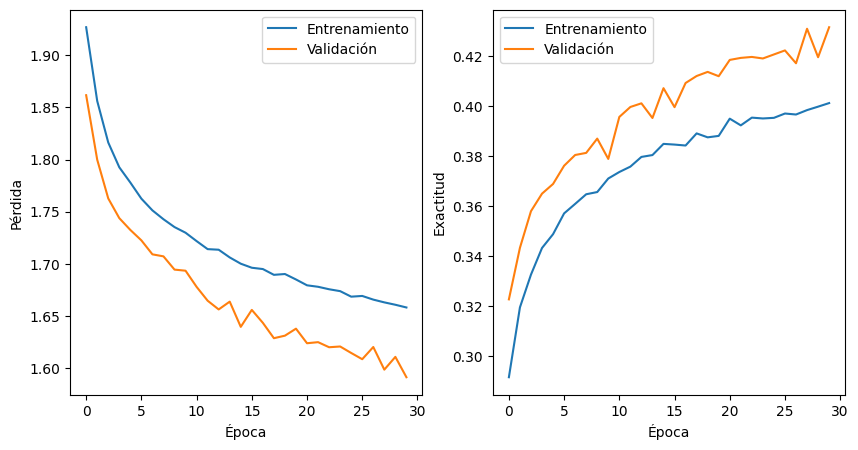

In [ ]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['perdida_ent'], label='Entrenamiento')
axs[0].plot(hist['perdida_val'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['exactitud_ent'], label='Entrenamiento')
axs[1].plot(hist['exactitud_val'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()

In [32]:
class Residual(nn.Module):
  def __init__(self,
               cent,
               csal):
    super(Residual, self).__init__()

    self.conv1 = nn.Conv2d(cent, csal, 3, padding = 'same')
    self.bn1 = nn.BatchNorm2d(csal)
    self.conv2 = nn.Conv2d(csal, csal, 3, padding = 'same')
    self.bn2 = nn.BatchNorm2d(csal)

    if cent != csal:
      self.conv1x1 = nn.Conv2d(cent, csal, 1)
    else:
      self.conv1x1 = None

  def forward(self, x):
    y = self.conv1(x)
    y = self.bn1(y)
    y = nn.functional.relu(y)
    y = self.conv2(y)
    y = self.bn2(y)

    if self.conv1x1:
      x = self.conv1x1(x)

    return nn.functional.relu(x + y)

In [33]:
class BloqueResNet(nn.Module):
  def __init__(self,
               cent,
               csal,
               k = 2):
    super(BloqueResNet, self).__init__()

    self.res = [Residual(cent, csal)]
    for i in range(1, k):
      self.res.append(Residual(csal, csal))
    self.res = nn.ModuleList(self.res)

  def forward(self, x):
    for r in self.res:
      x = r(x)
    return x

In [34]:
b = BloqueResNet(3, 32)
print(b(torch.rand(1, 3, 64, 64)).shape)

torch.Size([1, 32, 64, 64])


In [36]:
class ViT_CNN(nn.Module):
    def __init__(self, img_size, patch_size, out_dim, d_modelo,
                 depth, n_cabezas, mlp_dim, dropout):
        super().__init__()
        self.d_modelo = d_modelo

        # N = H*W/(P^2)
        self.n_patches = (img_size // patch_size) ** 2

        self.resnet=BloqueResNet(3, 32)

        input_projection = 32*(patch_size ** 2) # C*PP

        self.projection = nn.Linear(input_projection, d_modelo) #

        self.pos_embedding = nn.Parameter(
            torch.randn(1, self.n_patches + 1, d_modelo))


        self.cls_token = nn.Parameter(torch.randn(1, 1, d_modelo))

        bloques = [BloqueTransformer(d_modelo,
                                     n_cabezas,
                                     mlp_dim,
                                     dropout,
                                     masc = False) for _ in range(depth)]
        self.transformer = nn.Sequential(*bloques)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(d_modelo),
            nn.Linear(d_modelo, out_dim),
        )

    def forward(self, x):
        B = x.shape[0]

        # Patches
        # N x (P^2 * C)
        # Donde:
        # N = HW/P^2
        img_patches = rearrange(x, 'b c (x patch_x) (y patch_y) -> (b x y) c patch_x patch_y',  patch_x=patch_size, patch_y=patch_size)

        x=self.resnet(img_patches)

        img_patches = rearrange(x,'(b n) c x y-> b n (x y c)', b=B)

        # Linear Projection
        x = self.projection(img_patches)

        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat((cls_token, x), dim=1)
        x += self.pos_embedding

        x = self.transformer(x)
        x = x[:, 0, :]
        return self.mlp_head(x)

In [37]:
model = ViT_CNN(IMG_SIZE, patch_size, out_dim, d_modelo, depth, n_cabezas, mlp_dim, dropout)
disp = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(disp)
ecm = nn.CrossEntropyLoss(weight=None,
                              reduction='mean',
                              label_smoothing=0.1)
opt = Adam(model.parameters(),lr=1e-3)

#opt = SGD(model.parameters(), lr = 1e-3)

LOGDIR = './logs/'

model, mejor_conv, hist = entrena(model,
                                   ecm,
                                   exactitud,
                                   opt,
                                   trn_dl,
                                   val_dl,
                                   disp,
                                   LOGDIR + '/conv.pt',
                                   n_epocas=30,
                                   tbdir = LOGDIR)




Época 0: Perdida(E) = 1.949, exactitud(E) = 0.288, Perdida(V) = 1.933, exactitud(V) = 0.295

Época 1: Perdida(E) = 1.931, exactitud(E) = 0.293, Perdida(V) = 1.922, exactitud(V) = 0.295

Época 2: Perdida(E) = 1.882, exactitud(E) = 0.309, Perdida(V) = 1.843, exactitud(V) = 0.325

Época 3: Perdida(E) = 1.804, exactitud(E) = 0.337, Perdida(V) = 1.747, exactitud(V) = 0.357

Época 4: Perdida(E) = 1.741, exactitud(E) = 0.359, Perdida(V) = 1.689, exactitud(V) = 0.380

Época 5: Perdida(E) = 1.693, exactitud(E) = 0.378, Perdida(V) = 1.652, exactitud(V) = 0.401

Época 6: Perdida(E) = 1.653, exactitud(E) = 0.396, Perdida(V) = 1.656, exactitud(V) = 0.399

Época 7: Perdida(E) = 1.635, exactitud(E) = 0.404, Perdida(V) = 1.573, exactitud(V) = 0.434

Época 8: Perdida(E) = 1.611, exactitud(E) = 0.415, Perdida(V) = 1.578, exactitud(V) = 0.431

Época 9: Perdida(E) = 1.593, exactitud(E) = 0.423, Perdida(V) = 1.545, exactitud(V) = 0.447

Época 10: Perdida(E) = 1.580, exactitud(E) = 0.429, Perdida(V) = 1.54

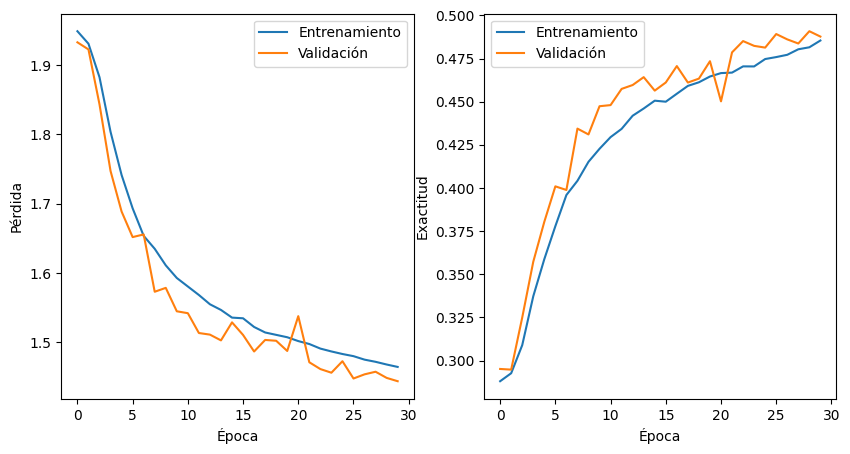

In [38]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(hist['perdida_ent'], label='Entrenamiento')
axs[0].plot(hist['perdida_val'], label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(hist['exactitud_ent'], label='Entrenamiento')
axs[1].plot(hist['exactitud_val'], label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Exactitud')
axs[1].legend()
plt.show()